In [68]:
from dataclasses import dataclass
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import json
from matplotlib import patheffects
from utils import dref_dataframe, dump_dref, fmt_bytes
import matplotlib
from scipy import integrate, stats
from statistics import stdev

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind6")


@dataclass
class BTimes:
    build: list[float]
    delay: list[float]
    clean: float | None
    drop: float
    cpu: dict[str, float]


def parse_frag(file: Path) -> pd.DataFrame:
    raw = file.read_text()
    data = ""
    for line in raw.splitlines():
        data += line + ((len(line) + 31) // 32 * 32 - len(line)) * "0"
    huge_pages = len(data)
    out = np.zeros(huge_pages)
    for i, char in enumerate(data):
        level = int(char)
        assert(0 <= level <= 9)
        out[i] = float(level)
    return pd.DataFrame(out)


def load_mode(max_mem: int, mode: str, path: Path, i=0) -> tuple[pd.DataFrame, BTimes]:
    data = pd.read_csv(path / f"out_{i}.csv")
    data["mode"] = mode
    if "time" not in data.columns:
        data["time"] = data.index
    data["time"] /= 60 # seconds to minutes
    if "total" not in data.columns:
        data["total"] = max_mem
    data["small"] = data["total"] - data["small"] * 2**12
    data["huge"] = data["total"] - data["huge"] * 2**(12+9)
    data["VM memory"] = data["rss"]
    del data["rss"]

    data = data.melt(
        id_vars=["mode", "time"],
        var_name="measurement",
        value_name="bytes",
        value_vars=["VM memory", "small", "huge", "cached"])

    raw: dict = json.load((path / f"times_{i}.json").open())
    times = BTimes(
        [v / 60 for v in x] if isinstance(x := raw["build"], list) else [x],
        [v / 60 for v in y] if isinstance(y := raw["delay"], list) else [y],
        raw["clean"] / 60 if "clean" in raw and raw["clean"] is not None else None,
        (raw["drop"] if "drop" in raw else raw["shrink"]) / 60,
        raw["cpu"]
    )
    return data, times


def load_data(max_mem: int, modes: dict[str, Path]) -> tuple[pd.DataFrame, list[BTimes]]:
    datas: list[pd.DataFrame] = []
    times: list[BTimes] = []
    for mode, path in modes.items():
        data, time = load_mode(max_mem, mode, path)
        datas.append(data)
        times.append(time)
    data = pd.concat(datas, ignore_index=True)
    return data, times


def y_at(data: pd.DataFrame, x: float, measurement="VM memory"):
    return data[data["measurement"] == measurement][(data["time"] - x).abs() < 2/60]["bytes"].max()


def calc_gib_min(data: pd.DataFrame, start: float, end: float) -> float:
    build_d = data[(start <= data["time"])
        & (data["time"] <= end)
        & (data["measurement"] == "VM memory")]
    return integrate.trapezoid(build_d["bytes"], x=build_d["time"]) / 1024**3


def relplot(
        max_mem: int, data: pd.DataFrame,
        times: list[BTimes], col_wrap=10,
        run="build"
) -> tuple[sns.FacetGrid, dict[str, float]]:
    col_wrap = min(col_wrap, len(data["mode"].unique()))
    p = sns.relplot(data=data, kind="line", x="time", y="bytes", col="mode", col_wrap=col_wrap,
                    hue="measurement", height=5.5, legend=False)
    p.set_titles("{col_name}")
    p.set(ylabel="Memory consumption [GiB]")
    p.set(xlabel="Time [min]")
    p.set(xlim=(0, None))
    p.set(ylim=(0, max_mem * 1.1))
    p.set(yticks=[x for x in range(0, max_mem + 1, 2*1024**3)],
        yticklabels=[str(x // 1024**3) for x in range(0, max_mem + 1, 2*1024**3)])

    modes = data["mode"].unique()
    extra_keys = {}

    for ax in p.axes:
        ax.get_lines()[0].set(zorder=10, linestyle=(0, (1, 1)))

    h = list(p.axes[0].get_lines())
    l = list(data["measurement"].unique())
    p.add_legend(dict(zip(l, h)), loc="upper center", bbox_to_anchor=(0.3, 0.04), ncol=7, frameon=True)

    p.refline(y=max_mem, color=sns.crayons["Gray"])
    for i, time in enumerate(times):
        axis = p.facet_axis(0, i)
        celld = data[data["mode"] == modes[i]]

        tstart = 0
        j = 0
        prefix = ""
        for tbuild, tdelay in zip(time.build, time.delay):
            if len(time.build) > 1:
                axis.axvspan(
                    xmin=tstart, xmax=tbuild, ymax=0.91, edgecolor="black",
                    facecolor="whitesmoke", zorder=-1)

                b_mid = tstart + (tbuild - tstart)/2
                axis.text(b_mid, max_mem * 1.02, run, horizontalalignment="center",
                            path_effects=[patheffects.withStroke(linewidth=3, foreground='white')])
            else:
                axis.axvline(x=tbuild, color="black", linewidth=3, zorder=1)

            gib_m = calc_gib_min(celld, tstart, tbuild)
            print(f"{modes[i]}: {gib_m:.2f} GiB*m, {tbuild - tstart:.2f} min")
            extra_keys[f"{modes[i]}/{j}/run/gib_m"] = gib_m
            extra_keys[f"{modes[i]}/{j}/run/time"] = tbuild - tstart

            gib = y_at(celld, tbuild + (tdelay - tbuild)/2) / 1024**3
            prefix += f"delay {gib:.2f} GiB, "
            extra_keys[f"{modes[i]}/{j}/delay/gib"] = gib
            tstart = tdelay
            j += 1

        tdelay = time.delay[-1]
        if time.clean is not None:
            axis.annotate(
                "clean",
                (tdelay, y_at(celld, tdelay, "huge") + max_mem/32),
                (tdelay, max_mem * 1.02),
                horizontalalignment="center",
                path_effects=[patheffects.withStroke(linewidth=3, foreground='white')],
                arrowprops={"facecolor": "black"},
                zorder=11)
            tdelay = time.clean
            gib = y_at(celld, tdelay) / 1024**3
            prefix += f"clean {gib:.2f} GiB, "
            extra_keys[f"{modes[i]}/clean/gib"] = gib

        axis.annotate(
            "drop",
            (tdelay, y_at(celld, tdelay, "huge") + max_mem/32),
            (tdelay, max_mem * 0.925),
            horizontalalignment="center",
            path_effects=[patheffects.withStroke(linewidth=3, foreground='white')],
            arrowprops={"facecolor": "black"},
            zorder=11)
        gib = y_at(celld, time.drop) / 1024**3
        prefix += f"drop {gib:.2f} GiB, "
        extra_keys[f"{modes[i]}/drop/gib"] = gib

        gib_m = calc_gib_min(celld, 0, time.drop)
        prefix += f"{gib_m:.2f} GiB*m"
        extra_keys[f"{modes[i]}/gib_m"] = gib_m

        print(f"{modes[i]}: {prefix}")

    return p, extra_keys


def visualize(max_mem: int, modes: dict[str, Path], save_as: str | None = None, col_wrap=10, run="build") -> sns.FacetGrid:
    data, times = load_data(max_mem, modes)
    p, extra_keys = relplot(max_mem, data, times, col_wrap, run=run)
    if save_as:
        p.savefig(Path("compiling") / f"{save_as}.pdf")
        p.savefig(Path("compiling") / f"{save_as}.svg")
        dref_dataframe(save_as, Path("compiling"), ["mode", "measurement", "time"], data)
        with (Path("compiling") / f"{save_as}_extra.dref").open("w+") as f:
            dump_dref(f, save_as, extra_keys)
    return p


## Clang

Buddy: 483.57 GiB*m, 41.36 min
Buddy: delay 16.04 GiB, clean 16.04 GiB, drop 16.04 GiB, 645.04 GiB*m
LLFree: 500.30 GiB*m, 40.62 min
LLFree: delay 16.07 GiB, clean 16.07 GiB, drop 16.07 GiB, 661.33 GiB*m


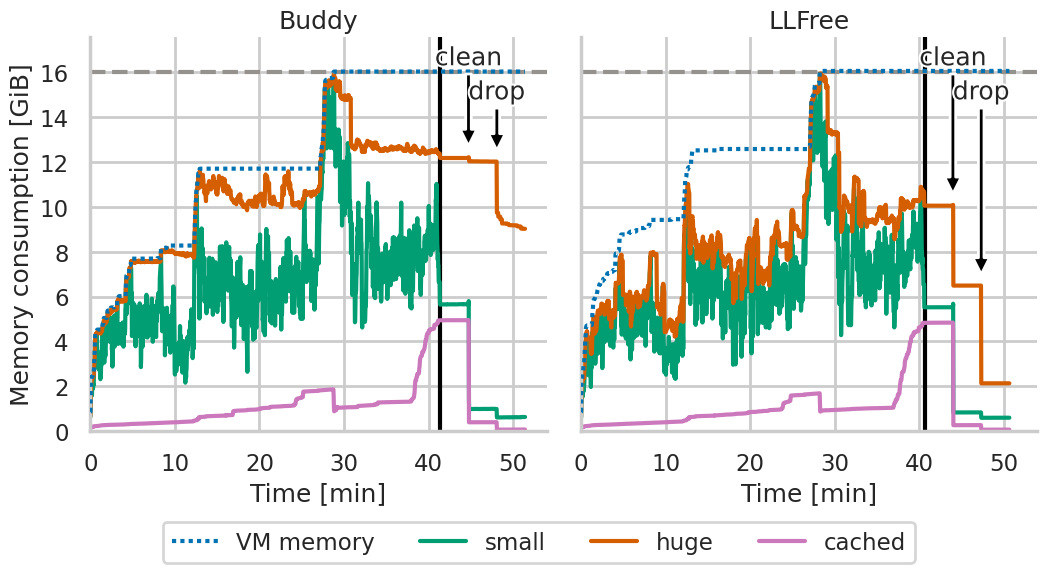

In [58]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "Buddy": Path("compiling/latest-clang-base-manual"),
    "LLFree": Path("compiling/latest-clang-llfree-manual"),
}, "clang-baseline")

virtio-balloon: 430.61 GiB*m, 41.28 min
virtio-balloon: delay 12.22 GiB, clean 11.55 GiB, drop 7.99 GiB, 538.36 GiB*m
HyperAlloc: 357.68 GiB*m, 40.79 min
HyperAlloc: delay 10.62 GiB, clean 6.86 GiB, drop 1.90 GiB, 422.96 GiB*m


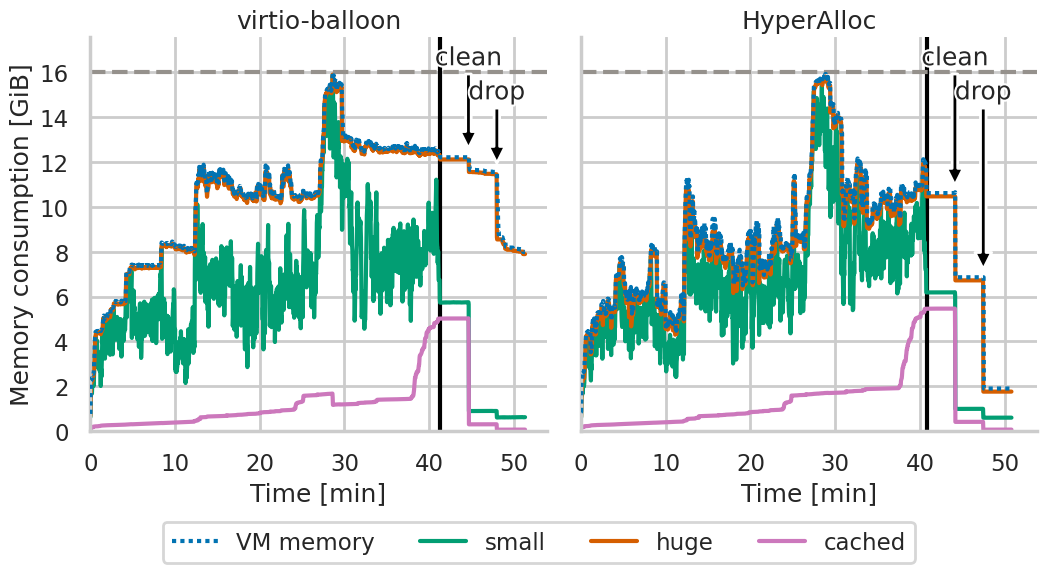

In [59]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "virtio-balloon": Path("compiling/latest-clang-base-auto"),
    "HyperAlloc": Path("compiling/latest-clang-llfree-auto"),
}, "clang-auto")

o=0 d=2000 c=32: 391.59 GiB*m, 48.54 min
o=0 d=2000 c=32: delay 6.50 GiB, clean 1.49 GiB, drop 1.05 GiB, 423.01 GiB*m
o=0 d=2000 c=512: 380.70 GiB*m, 48.48 min
o=0 d=2000 c=512: delay 6.33 GiB, clean 1.21 GiB, drop 0.84 GiB, 409.81 GiB*m


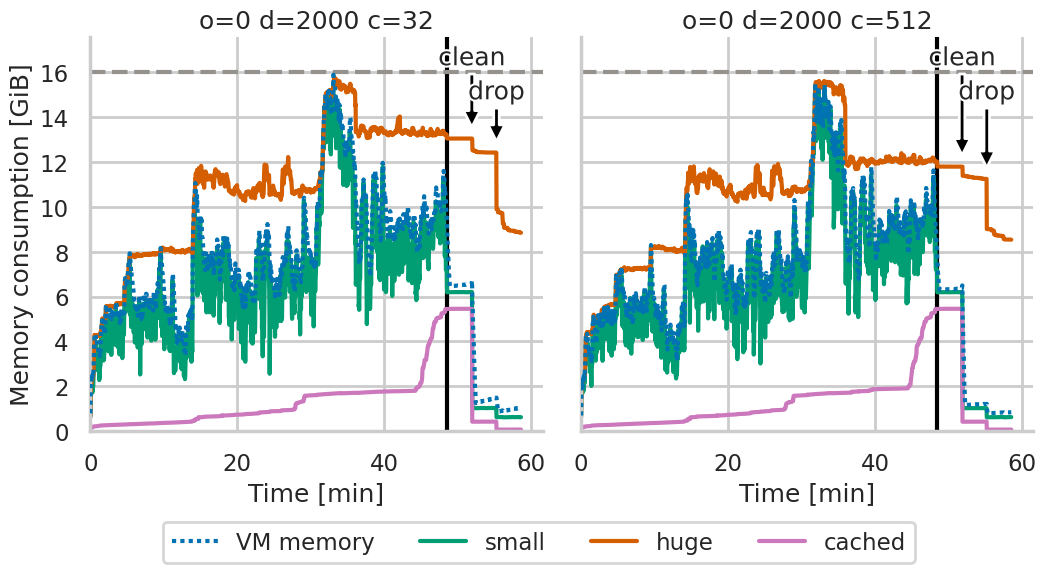

In [4]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "o=0 d=2000 c=32": Path("compiling/latest-clang-base-auto-o0-d2000-c32"),
    "o=0 d=2000 c=512": Path("compiling/latest-clang-base-auto-o0-d2000-c512"),
})

In [ ]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "virtio-mem+VFIO": Path("compiling/latest-clang-virtio-mem-vfio"),
    "HyperAlloc+VFIO": Path("compiling/latest-clang-llfree-auto-vfio"),
}, "clang-auto-vfio")

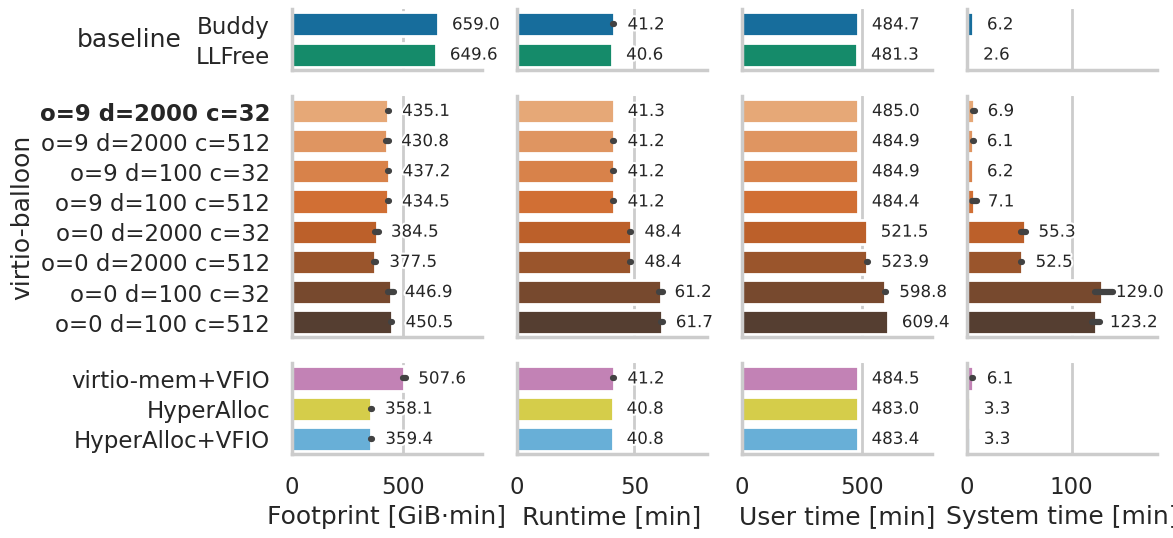

In [39]:
paths = {
    "Buddy": ("baseline", Path("compiling/latest-clang-base-manual")),
    "LLFree": ("baseline", Path("compiling/latest-clang-llfree-manual")),
    # "virtio-balloon": ("", Path("compiling/latest-clang-base-auto")),

    "o=9 d=2000 c=32": ("virtio-balloon", Path("compiling/latest-clang-base-auto-o9-d2000-c32")),
    "o=9 d=2000 c=512": ("virtio-balloon", Path("compiling/latest-clang-base-auto-o9-d2000-c512")),
    "o=9 d=100 c=32": ("virtio-balloon", Path("compiling/latest-clang-base-auto-o9-d100-c32")),
    "o=9 d=100 c=512": ("virtio-balloon", Path("compiling/latest-clang-base-auto-o9-d100-c512")),
    "o=0 d=2000 c=32": ("virtio-balloon", Path("compiling/latest-clang-base-auto-o0-d2000-c32")),
    "o=0 d=2000 c=512": ("virtio-balloon", Path("compiling/latest-clang-base-auto-o0-d2000-c512")),
    "o=0 d=100 c=32": ("virtio-balloon", Path("compiling/latest-clang-base-auto-o0-d100-c32")),
    "o=0 d=100 c=512": ("virtio-balloon", Path("compiling/latest-clang-base-auto-o0-d100-c512")),

    "virtio-mem+VFIO": ("", Path("compiling/latest-clang-virtio-mem-vfio")),
    "HyperAlloc": ("", Path("compiling/latest-clang-llfree-auto")),
    "HyperAlloc+VFIO": ("", Path("compiling/latest-clang-llfree-auto-vfio")),
}

raw = { "mode": [], "cat": [], "gib_m": [], "time": [], "time_user": [], "time_system": [], "time_total": [] }

max_mem = 16*1024**3
for name, (cat, path) in paths.items():
    build_sum = []
    gibm_sum = []
    for i in range(3):
        data, times = load_mode(max_mem, name, path, i)
        if name == "Buddy" or name == "LLFree":
            data.loc[data["measurement"] == "VM memory", "bytes"] = 16*1024**3

        raw["mode"].append(name)
        raw["cat"].append(cat)
        raw["time"].append(times.build[0])
        raw["time_user"].append(times.cpu["user"] / 60)
        raw["time_system"].append(times.cpu["system"] / 60)
        raw["time_total"].append(times.cpu["system"] / 60)
        raw["gib_m"].append(calc_gib_min(data, 0, times.build[0]))

data = pd.DataFrame(data=raw)
data = data.melt(id_vars=["mode", "cat"], value_vars=["gib_m", "time", "time_user", "time_system"], value_name="measurement")

p = sns.FacetGrid(data, col="variable", row="cat", height=2, aspect=1.5,
                  sharex="col", sharey="row",
                  gridspec_kws={'height_ratios': [2,8,3]})

def plot(data, **kwargs):
    palette = sns.palettes.color_palette("colorblind6", as_cmap=True)
    row = list(data["cat"])[0]
    if row == "virtio-balloon": kwargs["palette"] = "Oranges_d"
    elif row == "baseline": kwargs["palette"] = palette
    else: kwargs["palette"] = palette[3:]
    sns.barplot(**kwargs, data=data)

p = p.map_dataframe(plot, y="mode", x="measurement", orient="y", hue="mode")
p.set_titles(template="", col_template="", row_template="")
p.set_ylabels("")

p.figure.subplots_adjust(hspace=0.2)

for [row, col], ax in p.axes_dict.items():
    if col == "time":
        ax.set_xlabel("Runtime [min]")
    elif col.startswith("time"):
        ax.set_xlabel(f"{col[5].upper()}{col[6:]} time [min]")
    else:
        ax.set_xlabel("Footprint [GiB·min]")
    ax.set_xlim(0, data[data["variable"] == col]["measurement"].max() * 1.3)

    if col == "gib_m":
        if row == "baseline":
            ax.set_ylabel(row, rotation=0, labelpad=10, ha="right", va="center")
        else:
            ax.set_ylabel(row)

    for c in ax.containers:
        ax.bar_label(c, fmt=lambda x: f"{x:.1f}", fontsize=12, padding=10,
                        path_effects=[patheffects.withStroke(linewidth=3, foreground='white')])

    labels = ax.get_yticklabels()
    for l in labels:
        if l.get_text() == "o=9 d=2000 c=32": l.set(fontweight="bold")

p.savefig("compiling/clang.pdf", bbox_inches="tight")
dref_dataframe("clang", Path("compiling"), ["cat", "mode", "variable"], data)


In [41]:
host_time = data[data["variable"] == "time_user"][["mode", "measurement"]]
host_time["measurement"] += data[data["variable"] == "time_system"]["measurement"].array
host_time.groupby("mode").describe()


measurement                                                 \
                       count        mean        std         min         25%   
mode                                                                          
Buddy                    3.0  490.925333   0.688920  490.150167  490.654167   
HyperAlloc               3.0  486.303889   0.214845  486.074667  486.205500   
HyperAlloc+VFIO          3.0  486.725778   0.438804  486.230167  486.556250   
LLFree                   3.0  483.929222   0.307754  483.574000  483.836083   
o=0 d=100 c=32           3.0  727.759000  11.371111  719.511333  721.273167   
o=0 d=100 c=512          3.0  732.609000   4.943967  727.686167  730.126583   
o=0 d=2000 c=32          3.0  576.816056   3.344581  572.971333  575.696917   
o=0 d=2000 c=512         3.0  576.364500   0.741261  575.603667  576.004500   
o=9 d=100 c=32           3.0  491.156667   0.832180  490.226000  490.820417   
o=9 d=100 c=512          3.0  491.502556   2.975496  489.304500  489.809583   
o=9 d=2000 c=32          3.0  491.903611   1.216764  490.982000  491.214000   
o=9 d=2000 c=512         3.0  491.048889   0.787099  490.503167  490.597750   
virtio-mem+VFIO          3.0  490.591778   0.606164  489.980000  490.291583   

                                                      
                         50%         75%         max  
mode                                                  
Buddy             491.158167  491.312917  491.467667  
HyperAlloc        486.336333  486.418500  486.500667  
HyperAlloc+VFIO   486.882333  486.973583  487.064833  
LLFree            484.098167  484.106833  484.115500  
o=0 d=100 c=32    723.035000  731.882833  740.730667  
o=0 d=100 c=512   732.567000  735.070417  737.573833  
o=0 d=2000 c=32   578.422500  578.738417  579.054333  
o=0 d=2000 c=512  576.405333  576.744917  577.084500  
o=9 d=100 c=32    491.414833  491.622000  491.829167  
o=9 d=100 c=512   490.314667  492.601583  494.888500  
o=9 d=2000 c=32   491.446000  492.364417  493.282833  
o=9 d=2000 c=512  490.692333  491.321750  491.951167  
virtio-mem+VFIO   490.603167  490.897667  491.192167

In [85]:
# Relative difference
budiff = pd.DataFrame((host_time[host_time["mode"] == "o=9 d=2000 c=32"]["measurement"].array - host_time[host_time["mode"] == "Buddy"]["measurement"].array) / host_time[host_time["mode"] == "Buddy"]["measurement"].array)
(min, max) = stats.t.interval(0.95, len(budiff) - 1, loc=budiff.mean(), scale=stats.sem(budiff))
print(min, max, f"{(min+max)[0]/2 * 100:.2} +- {(max-min)[0]/2 * 100:.2}")
budiff.describe().T


[-0.00347198] [0.00745787] 0.2 +- 0.55


,count,mean,std,min,25%,50%,75%,max
0,3.0,0.001993,0.0022,-0.000044,0.000827,0.001697,0.003011,0.004326


In [86]:
# Relative difference
lldiff = pd.DataFrame((host_time[host_time["mode"] == "HyperAlloc"]["measurement"].array - host_time[host_time["mode"] == "LLFree"]["measurement"].array) / host_time[host_time["mode"] == "LLFree"]["measurement"].array)
(min, max) = stats.t.interval(0.95, len(lldiff) - 1, loc=lldiff.mean(), scale=stats.sem(lldiff))
print(min, max, f"{(min+max)[0]/2 * 100:.2} +- {(max-min)[0]/2 * 100:.2}")
lldiff.describe().T


[0.00236638] [0.00744856] 0.49 +- 0.25


,count,mean,std,min,25%,50%,75%,max
0,3.0,0.004907,0.001023,0.004083,0.004335,0.004587,0.00532,0.006052


## SPEC17 Blender

virtio-balloon: 41.79 GiB*m, 5.47 min
virtio-balloon: 42.58 GiB*m, 5.47 min
virtio-balloon: 43.04 GiB*m, 5.47 min
virtio-balloon: delay 3.25 GiB, delay 5.11 GiB, delay 5.80 GiB, drop 4.37 GiB, 202.24 GiB*m
HyperAlloc: 41.76 GiB*m, 5.47 min
HyperAlloc: 42.11 GiB*m, 5.43 min
HyperAlloc: 42.54 GiB*m, 5.48 min
HyperAlloc: delay 1.86 GiB, delay 2.25 GiB, delay 2.62 GiB, drop 1.28 GiB, 158.67 GiB*m


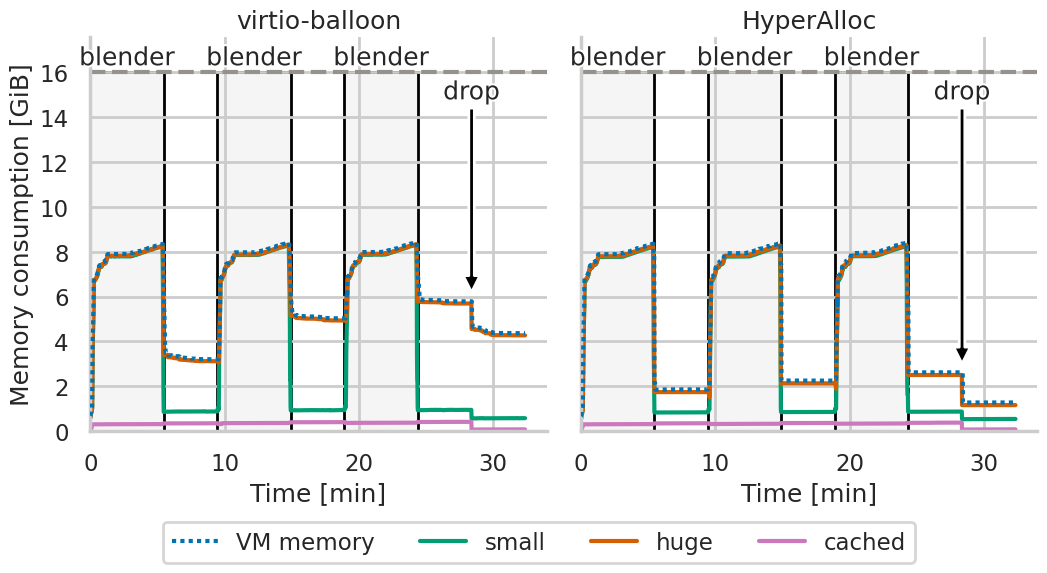

In [184]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "virtio-balloon": Path("compiling/latest-blender-base-auto"),
    "HyperAlloc": Path("compiling/latest-blender-llfree-auto"),
}, "blender-auto", run="blender")

# Testing

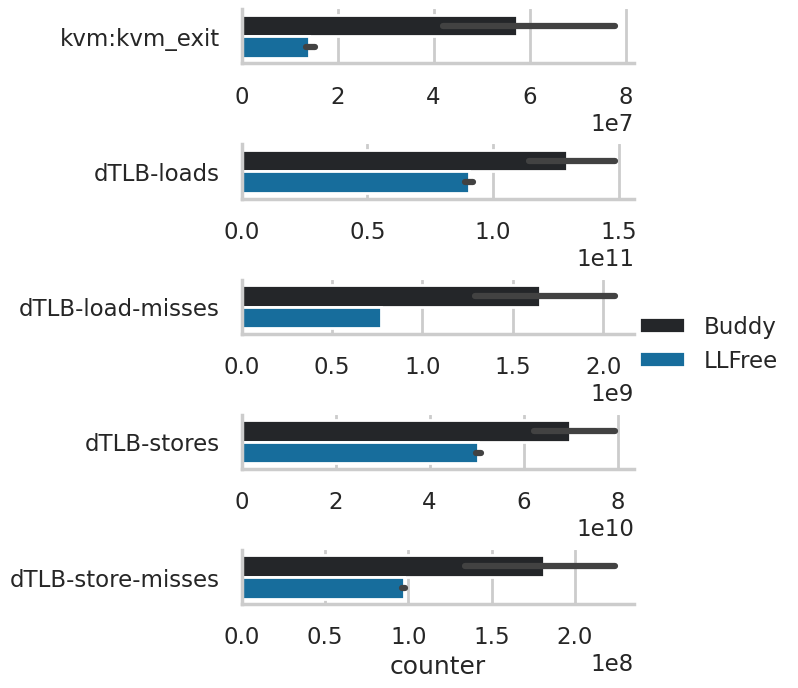

In [45]:
def parse_perf(path: Path, count: int) -> dict[str, list[float]]:
    out = {}
    for i in range(count):
        f_path = path / f"{i}_perfstats.json"
        with f_path.open() as f:
            for line in f.readlines():
                if line.strip() != "":
                    d = json.loads(line)
                    out.setdefault("event", []).append(d["event"])
                    out.setdefault("counter", []).append(float(d["counter-value"]))
    return out

data1 = pd.DataFrame(parse_perf(Path("compiling/241011-165926-clang-base-auto"), 3))
data1["mode"] = "Buddy"
data2 = pd.DataFrame(parse_perf(Path("compiling/241014-145752-clang-llfree-manual"), 3))
data2["mode"] = "LLFree"
data = pd.concat([data1, data2], ignore_index=True)

p = sns.FacetGrid(data, row="event", height=1.5, aspect=5, sharey=False, sharex=False)
p.map_dataframe(sns.barplot, x="counter", y="event", hue="mode")
p.set_ylabels("")
p.set_titles("")
p.add_legend()
p.figure.subplots_adjust(hspace=1.5)


o0-d2000-c32: 0.38 GiB*m, 5.86 s
o0-d2000-c32: delay 6.80 GiB, drop 0.67 GiB, 1.87 GiB*m
o0-d2000-c512: 0.38 GiB*m, 5.81 s
o0-d2000-c512: delay 0.57 GiB, drop 0.53 GiB, 0.73 GiB*m
o0-d100-c32: 0.48 GiB*m, 5.96 s
o0-d100-c32: delay 0.56 GiB, drop 0.52 GiB, 0.65 GiB*m
o0-d100-c512: 0.34 GiB*m, 5.98 s
o0-d100-c512: delay 0.56 GiB, drop 0.53 GiB, 0.60 GiB*m
o9-d2000-c32: 0.66 GiB*m, 5.96 s
o9-d2000-c32: delay 7.26 GiB, drop 2.57 GiB, 2.31 GiB*m
o9-d2000-c512: 0.56 GiB*m, 5.82 s
o9-d2000-c512: delay 2.89 GiB, drop 2.83 GiB, 1.48 GiB*m
o9-d100-c32: 0.38 GiB*m, 5.81 s
o9-d100-c32: delay 2.97 GiB, drop 2.90 GiB, 1.47 GiB*m
o9-d100-c512: 0.39 GiB*m, 5.79 s
o9-d100-c512: delay 2.75 GiB, drop 2.53 GiB, 1.38 GiB*m


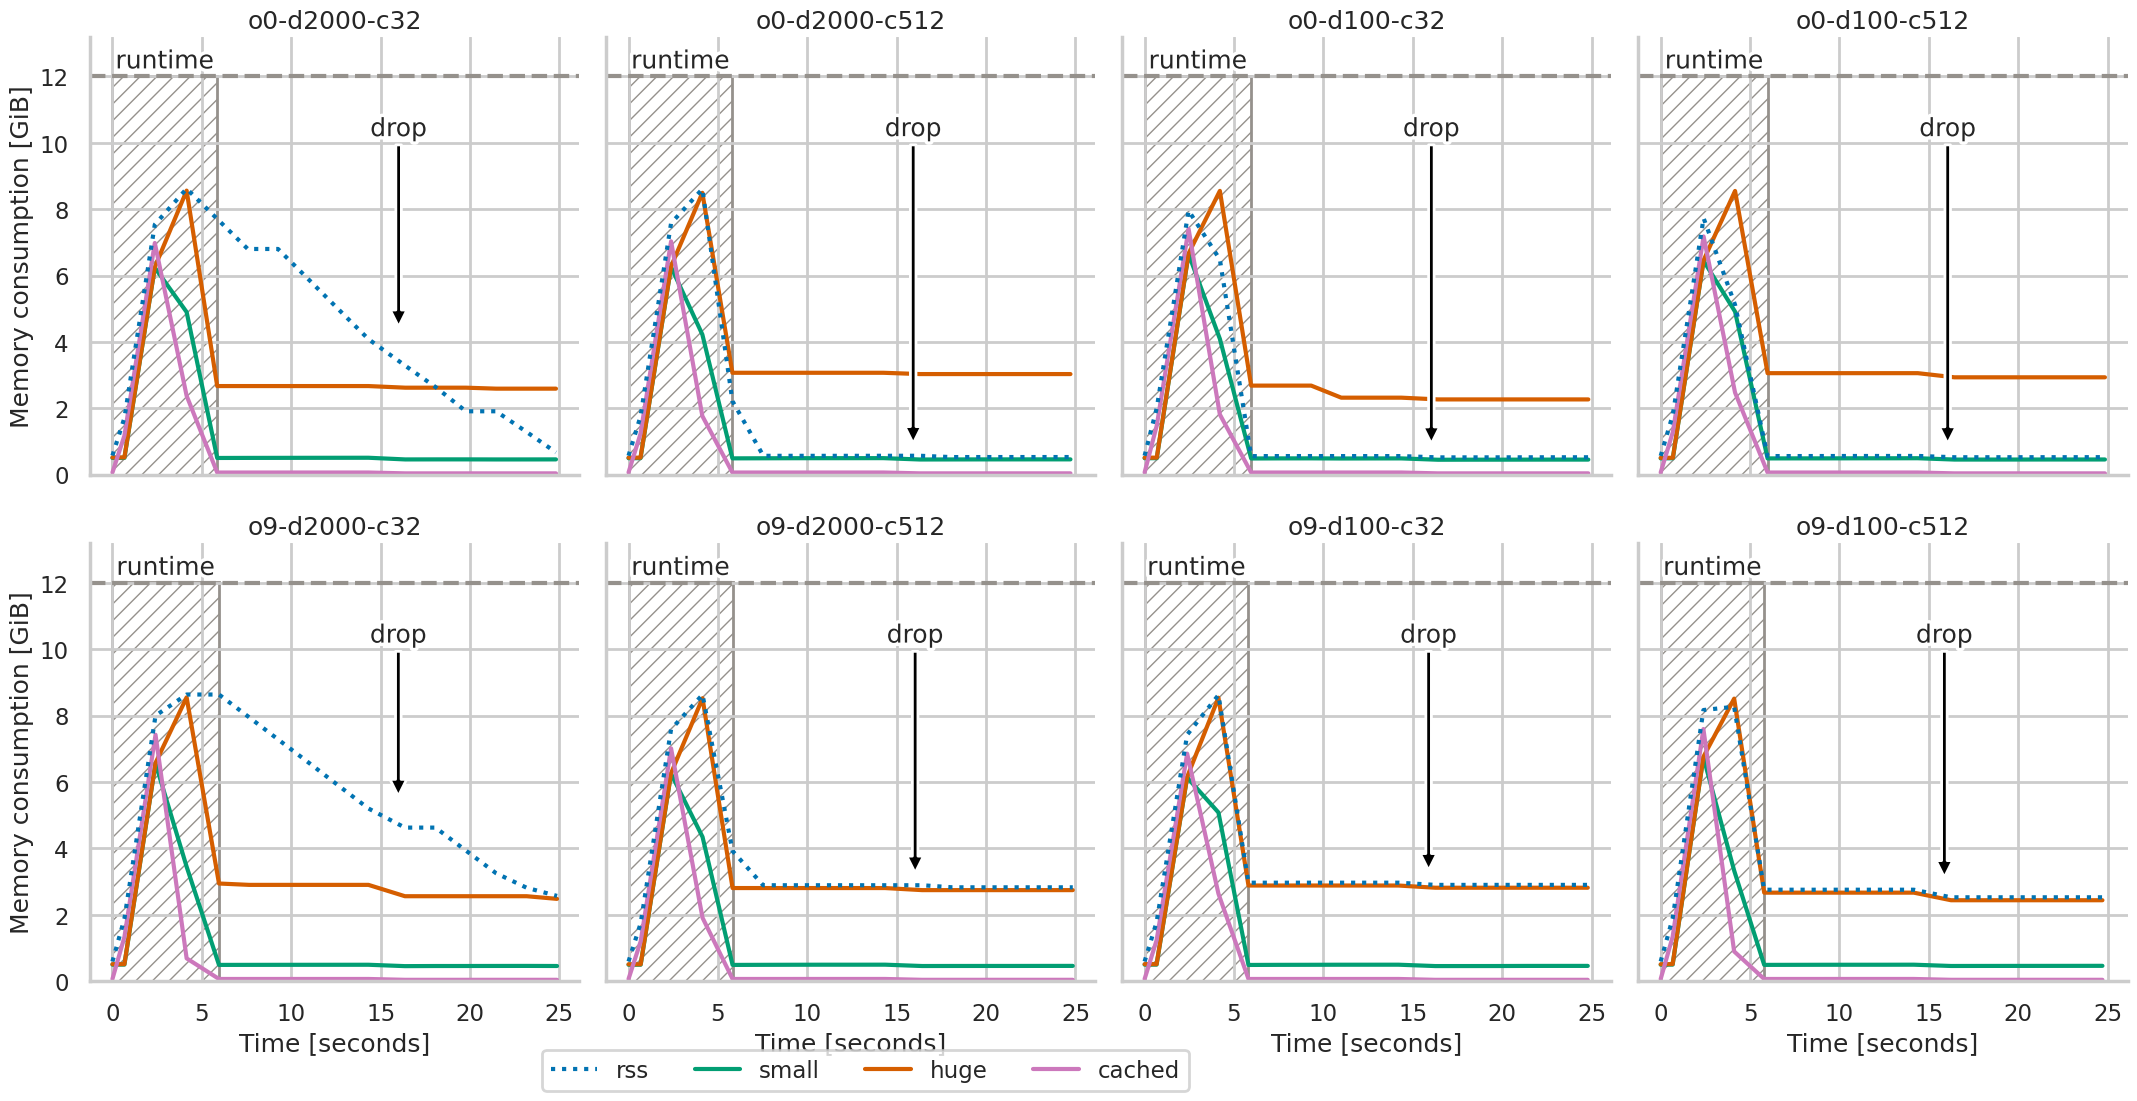

In [3]:
paths = sorted(list(Path("compiling").glob("240826-16*-base-auto-o*-d*-c*")))

modes = { p.stem[24:]: p for p in paths }

max_mem = 12*1024**3
p = visualize(max_mem, modes, col_wrap=4)

In [3]:
from matplotlib import colors
import matplotlib.pyplot as plt

def cscale(rgba: tuple[float, float, float, float], m: float) -> tuple[float, float, float, float]:
    return (rgba[0] * m, rgba[1] * m, rgba[2] * m, rgba[3])

def cmap_extreme(map: colors.Colormap, min=0, max=1) -> colors.Colormap:
    class Wrap(colors.Colormap):
        def __init__(self, cmap: colors.Colormap):
            self.cmap = cmap
        def __getattr__(self, name):
            if name == "cmap": return self.cmap
            return getattr(self.cmap, name)
        def __eq__(self, other):
            self.cmap.__eq__(other)
        def __copy__(self):
            Wrap(self.cmap.__copy__())
        def __call__(self, X, alpha=None, bytes=False):
            if isinstance(X, np.ndarray):
                X = X - (X <= min) + (X >= max)
            if isinstance(X, float) or isinstance(X, int):
                if X <= min:
                    return self.cmap(X - 1.0, alpha, bytes)
                if X >= max:
                    return self.cmap(X + 1.0, alpha, bytes)
            return self.cmap(X, alpha, bytes)

    return Wrap(map.with_extremes(
        under=cscale(map(-1.0), 0.5), over=cscale(map(2.0), 0.5)))

LLFree 16M: 210.64 GiB*m, 1261 s
LLFree 16M: delay 11.83 GiB, clean 8.84 GiB, drop 2.29 GiB, 287.26 GiB*m
LLFree 128M: 210.77 GiB*m, 1262 s
LLFree 128M: delay 12.24 GiB, clean 10.28 GiB, drop 3.23 GiB, 296.60 GiB*m
LLFree 1G: 245.80 GiB*m, 1260 s
LLFree 1G: delay 12.93 GiB, clean 11.10 GiB, drop 6.83 GiB, 348.62 GiB*m


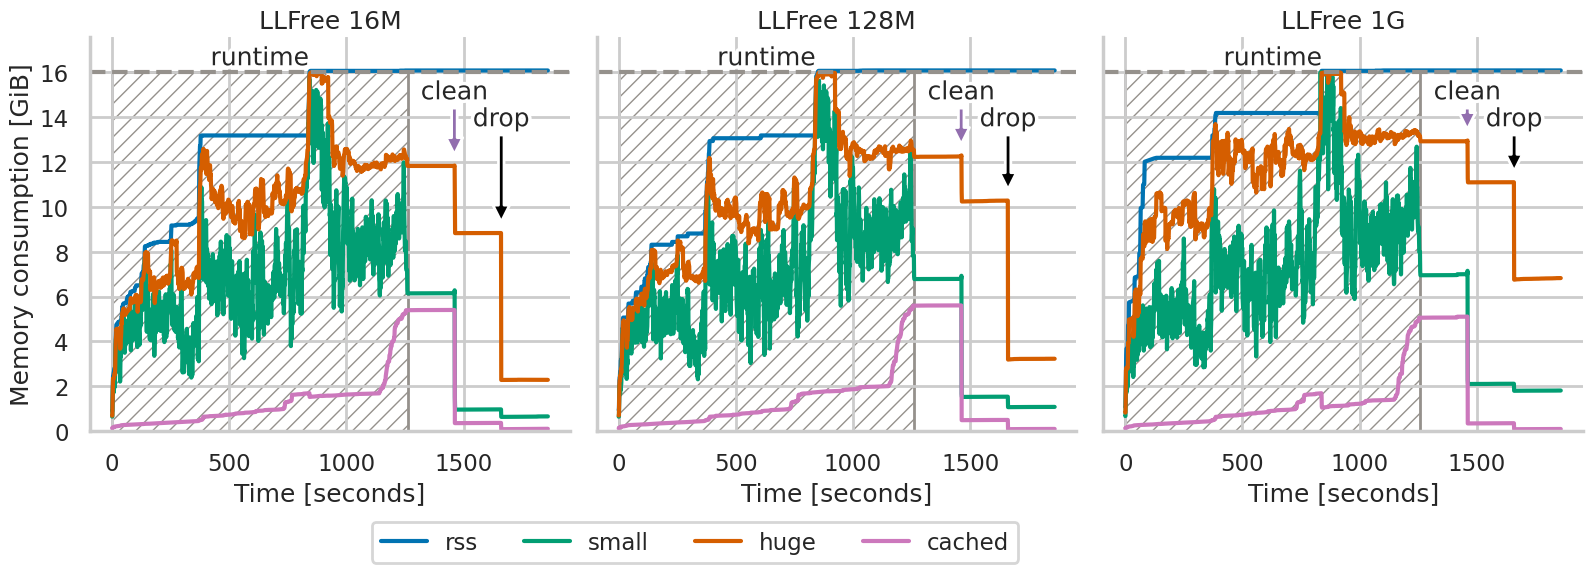

In [11]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "LLFree 16M": Path("compiling/240603-234305-clang-llfree-test"),
    "LLFree 128M": Path("compiling/240603-153327-clang-llfree-test"),
    "LLFree 1G": Path("compiling/240604-175853-clang-llfree-test"),
})

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210]


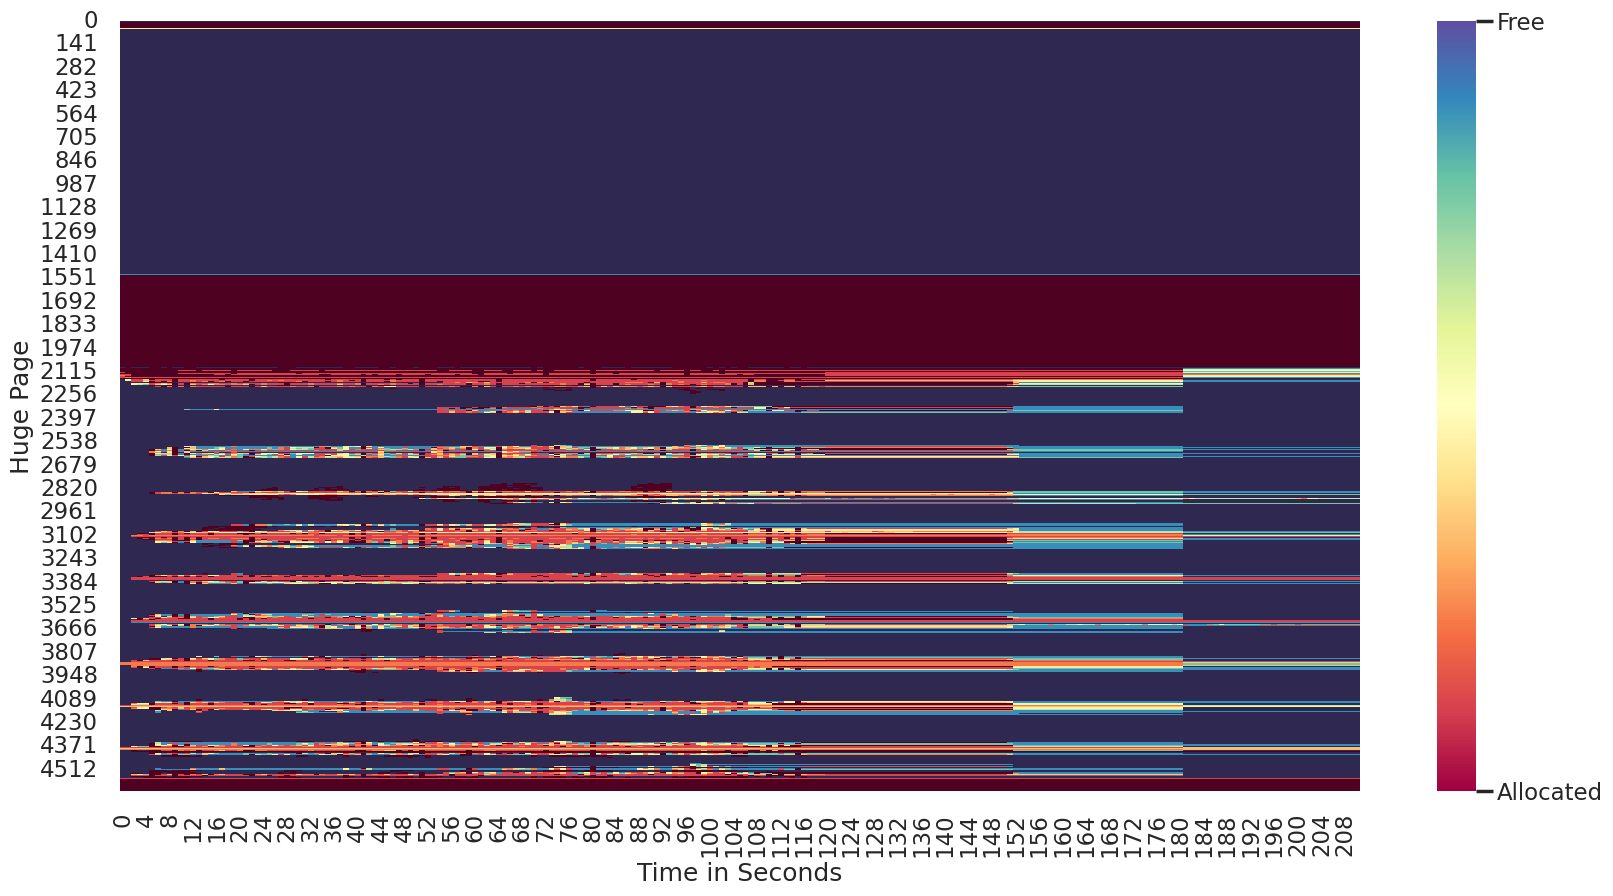

In [9]:
root = Path("compiling/240530-171416-linux-llfree-test")

cmap = cmap_extreme(sns.color_palette("Spectral", as_cmap=True, n_colors=10))

data = {}
for file in root.glob("frag_0_*.txt"):
    try:
        i = int(file.stem[7:])
        data[i] = parse_frag(file)
    except Exception:
        pass
print(sorted(data.keys()))

frames = []
for i, frame in sorted(list(data.items()), key=lambda x: x[0]):
    frames.append(frame)
data = pd.concat(frames, axis=1, ignore_index=True)
data *= 512 / 9

fix, ax = plt.subplots()
fix.set_figwidth(20)
fix.set_figheight(10)
fix.set_figheight(10)
fix.set_facecolor("white")
p = sns.heatmap(data, ax=ax, cmap=cmap)
p.set_xlabel("Time in Seconds")
p.set_ylabel("Huge Page")

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 512])
colorbar.set_ticklabels(["Allocated", "Free"])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210]


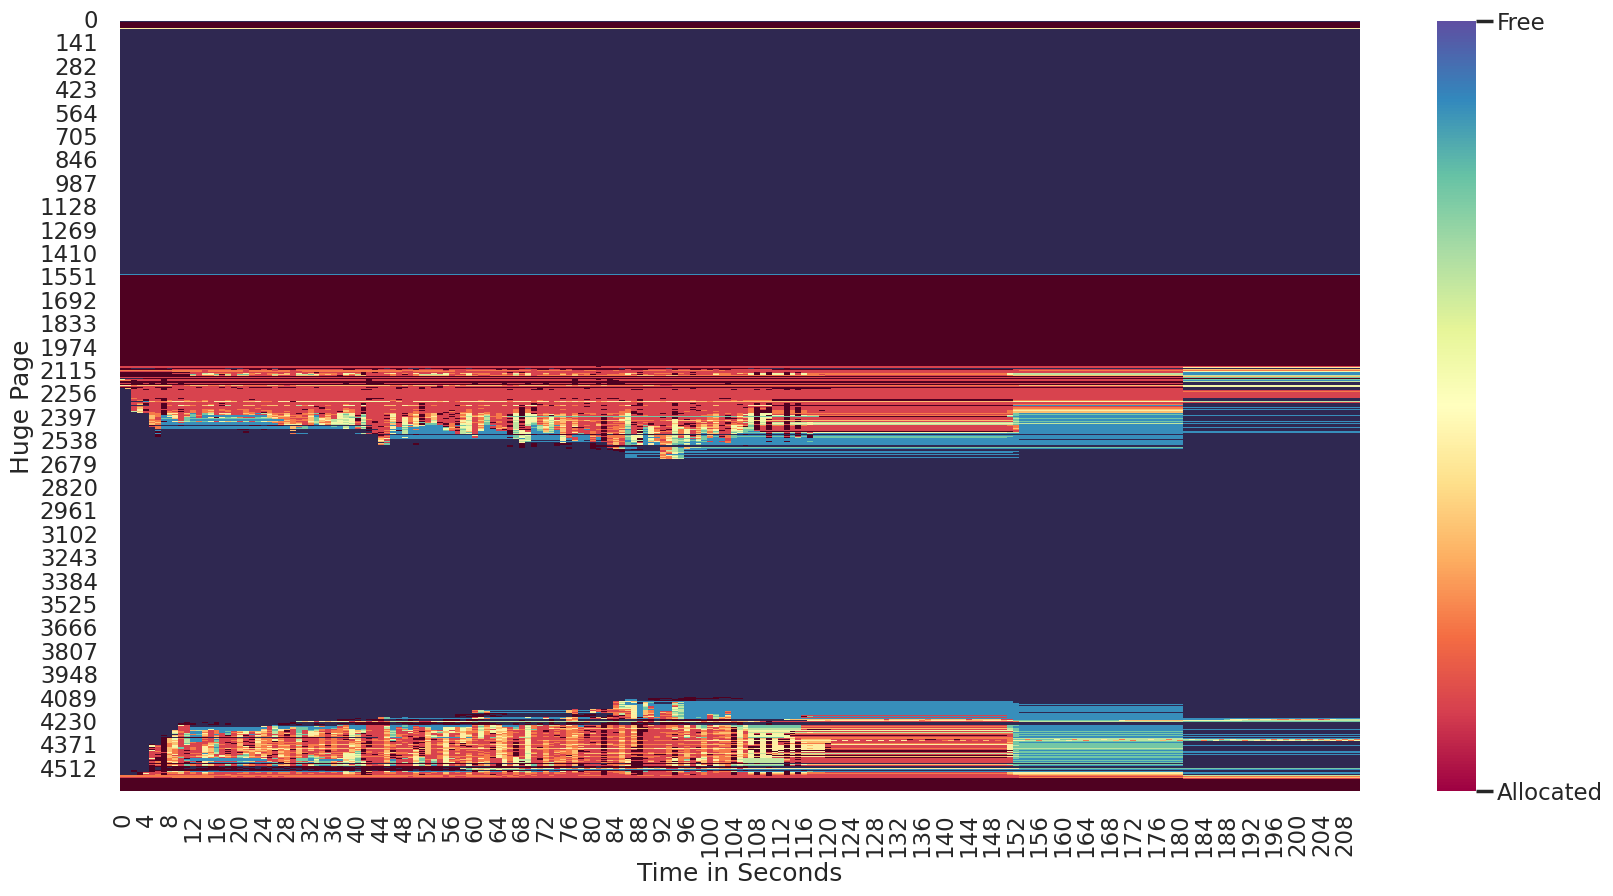

In [11]:
root = Path("compiling/240530-173108-linux-llfree-test")

cmap = cmap_extreme(sns.color_palette("Spectral", as_cmap=True, n_colors=10))

data = {}
for file in root.glob("frag_0_*.txt"):
    try:
        i = int(file.stem[7:])
        data[i] = parse_frag(file)
    except Exception:
        pass
print(sorted(data.keys()))

frames = []
for i, frame in sorted(list(data.items()), key=lambda x: x[0]):
    frames.append(frame)
data = pd.concat(frames, axis=1, ignore_index=True)
data *= 512 / 9

fix, ax = plt.subplots()
fix.set_figwidth(20)
fix.set_figheight(10)
fix.set_figheight(10)
fix.set_facecolor("white")
p = sns.heatmap(data, ax=ax, cmap=cmap)
p.set_xlabel("Time in Seconds")
p.set_ylabel("Huge Page")

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 512])
colorbar.set_ticklabels(["Allocated", "Free"])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

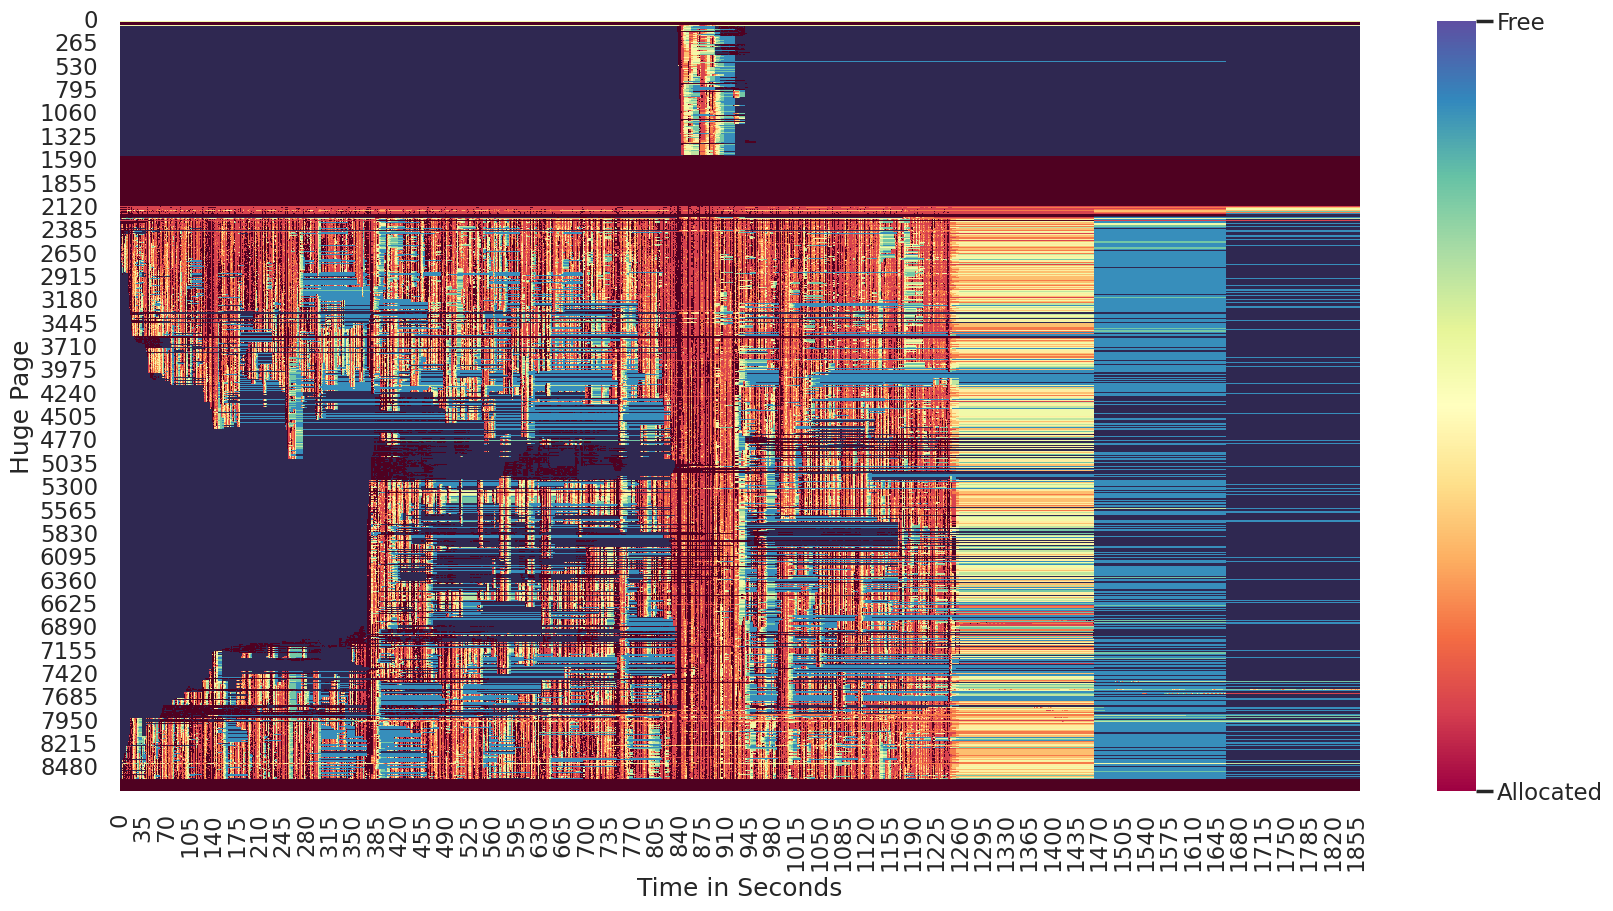

In [4]:
root = Path("compiling/240603-234305-clang-llfree-test")

cmap = cmap_extreme(sns.color_palette("Spectral", as_cmap=True, n_colors=10))

data = {}
for file in root.glob("frag_0_*.txt"):
    try:
        i = int(file.stem[7:])
        data[i] = parse_frag(file)
    except Exception:
        pass
print(sorted(data.keys()))

frames = []
for i, frame in sorted(list(data.items()), key=lambda x: x[0]):
    frames.append(frame)
data = pd.concat(frames, axis=1, ignore_index=True)
data *= 512 / 9

fix, ax = plt.subplots()
fix.set_figwidth(20)
fix.set_figheight(10)
fix.set_figheight(10)
fix.set_facecolor("white")
p = sns.heatmap(data, ax=ax, cmap=cmap)
p.set_xlabel("Time in Seconds")
p.set_ylabel("Huge Page")

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 512])
colorbar.set_ticklabels(["Allocated", "Free"])